In [1]:
with open('../../../TruePIE/input/word_embedding.txt', 'r') as f:
    lines = f.readlines()

lines[0]

'3000000 300\n'

In [22]:
import pandas as pd
import pickle
from tqdm import tqdm
df = pd.DataFrame()
words = []
embs = []
for line in tqdm(lines):
    word = line.split(' ')[0]
    emb = line.split(' ')[1:]
    for i in range(len(emb)):
        emb[i] = float(emb[i])
    words.append(word)
    embs.append(emb)
df['word'] = words
df['emb'] = embs

df.to_pickle('../../../TruePIE/input/word_embedding.pickle')

100%|██████████| 3000001/3000001 [05:10<00:00, 9647.33it/s] 


In [26]:
embedding_dict = pickle.load(open('../../../TruePIE/input/word_embedding.pickle','rb'))

In [71]:
'United_Nations' in embedding_dict['word'].to_numpy()

True

In [ ]:
import numpy as np
from collections import defaultdict
import pickle
from tqdm import tqdm

embedding_dict = pickle.load(open('../../../TruePIE/input/word_embedding.pickle','rb'))
pattern_file = '../../../TruePIE/input/pattern.txt'
words = embedding_dict['word'].to_numpy()
embs = embedding_dict['emb'].to_numpy()
progress = 0

def emb_of_word(word, words, embs):
    if word not in words:
        terms = word.split('_')
    else:
        idx = np.where(words == word)[0]
        return word, np.array(embs[idx][0])
    cap_ = ''
    for term in terms:
        cap_ += term.capitalize() + '_'
    cap_ = cap_[:-1]
    if cap_ not in words:
        return None, np.zeros(300)
    else:
        idx = np.where(words == cap_)[0]
        return cap_, np.array(embs[idx][0])

emb_e_v_pairs = {}
feature_vec1 = dict()
ev_diff_count = defaultdict(list)
with open(pattern_file) as f:
    patterns, pattern2patternid = [], {}
    for line in tqdm(f):
        emb_e_v_pair = {}
        row = line.rstrip('\n').split('\t')
        (wd_e, emb_e), (wd_v, emb_v) = emb_of_word(row[3], words, embs), emb_of_word(row[4], words, embs)
        if wd_e is None or wd_v is None:
            continue
        emb_e_v_pair['e'] = emb_e
        emb_e_v_pair['v'] = emb_v
        emb_e_v_pairs[wd_e + ',' + wd_v] = emb_e_v_pair

        if row[0] not in feature_vec1:
            pattern = row[0] + '\t' + row[1] + '\t' + row[2]
            row[0] = row[0].replace('_', ' ')
            pattern_t = row[0].split()
            pattern_t = [element for i, element in enumerate(pattern_t) if i not in (row[1], row[2])]

            for i in range(len(pattern_t)):
                if pattern_t[i] == ',':
                    pattern_t[i] = '</s>'

            pattern_emb = [np.array(embs[np.where(words == w)[0]][0]) for w in pattern_t if w in words]

            if not pattern_emb:
                continue

            if not pattern in pattern2patternid:
                patterns.append(pattern)
                pattern2patternid[pattern] = len(pattern2patternid)
            patternid = pattern2patternid[pattern]
            feature_vec1[patternid] =np.mean(pattern_emb, axis=0).tolist()

        patternid = pattern2patternid[pattern]
        ev_diff_count[patternid].append(((emb_e-emb_v).tolist(), row[5]))

        
print('length of patterns: %s\n' % len(patterns))
with open('../../../TruePIE/input/feature/'+'pattern2patternid'+ '.pickle', 'wb') as fp:
    pickle.dump(pattern2patternid, fp)
            
with open('../../../TruePIE/input/feature/'+'patternid2pattern'+ '.pickle', 'wb') as fp:
	pickle.dump(patterns, fp)
        
feature_vec2 = {pattern: np.mean([tpl[0] for tpl in ev_diff_count[pattern]], axis=0).tolist() for pattern in ev_diff_count}

print('length of patterns (feature1): %s\n' % len(feature_vec1))
with open('../../../TruePIE/input/feature/'+'feature1'+ '.pickle', 'wb') as fp:
    pickle.dump(feature_vec1, fp)
print('length of patterns (feature2_mean): %s\n' % len(feature_vec2))
with open('../../../TruePIE/input/feature/'+'feature2_mean'+ '.pickle', 'wb') as fp:
    pickle.dump(feature_vec2, fp)
            
        

In [101]:
np.mean(np.array(embs[np.where(words == 'founder')[0]][0]) - np.array(embs[np.where(words == 'FOUNDER')[0]][0]))

0.0020951839426666635

In [99]:
np.mean(np.array(embs[np.where(words == 'ceo')[0]][0]) - np.array(embs[np.where(words == 'FOUNDER')[0]][0]))

0.01601617795933333

In [22]:
np.where(words == 'P1kaboodle')

(array([], dtype=int64),)

In [2]:

import gensim
# Need the interactive Tools for Matplotlib
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

model = gensim.models.KeyedVectors.load_word2vec_format('../../../pretrianed-word2vec/GoogleNews-vectors-negative300.bin.gz', binary=True)


In [115]:

def get_similar_word2vec_words(model, word):
    word_labels = [word]
    close_words = model.similar_by_word(word)
    for wrd_score in close_words:
        word_labels.append(wrd_score[0])

    return word_labels


def display_word2vec_plot(model, word_labels):
    
    arr = np.empty((0,300), dtype='f')
    
    # add the vector for each of the closest words to the array
    for w in word_labels:
        if w[0] == 'p':
            wrd_vector = model[w.split(':')[1]]
        else:
            wrd_vector = model[w]
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=123)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

In [116]:
import random
i = 1
words= []
keys = [*emb_e_v_pairs.keys()]
random.shuffle(keys)
for key in keys:
    E, V = key.split(',')
    E, V = f'p{i}:' + E, f'p{i}:' + V
    words.append(E)
    words.append(V)
    i += 1
    if i > 10:
        break
    
words.append('founder')
words.append('company')


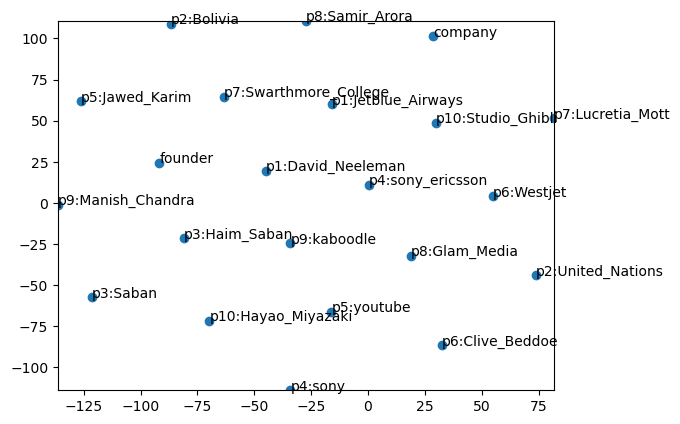

In [117]:
display_word2vec_plot(model, words)

In [126]:
import nltk
corpus_ = '../../../../../data/pj20/corpus_text_low.txt'
with open(corpus_) as f:
    data = f.readlines()

results = []
for sentence in tqdm(data):
    sentence_results = []
    for s in sentence:
        sentence_results.append(nltk.word_tokenize(sentence))
    results.append(sentence_results)


100%|██████████| 52803/52803 [11:30<00:00, 76.50it/s]  


In [ ]:
import nltk
corpus_ = '../../../../../data/pj20/corpus_text_low.txt'
with open(corpus_) as f:
    data = f.readlines()

results = []
for sentence in tqdm(data):
    sentence_results = []
    for s in sentence:
        sentence_results.append(nltk.word_tokenize(sentence))
    results.append(sentence_results)

In [ ]:
from gensim.models import KeyedVectors, Word2Vec

model_new = Word2Vec(size=300, min_count=1)
model_new.build_vocab(results)
total_examples = model_new.corpus_count
model_new.build_vocab(list(model.vocab.keys()), update=True)
model_new.intersect_word2vec_format('../../../pretrianed-word2vec/GoogleNews-vectors-negative300.bin.gz', binary=True, lockf=1.0)
model_new.train(results, total_examples=total_examples, epochs=model_new.iter)